In [ ]:
!pip install SimpleITK
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.6 MB/s eta 0:00:00


In [ ]:
import os
import SimpleITK as sitk
import numpy as np
import gc
import torch
from torch import nn
from google.colab import drive
import pickle
import monai
from monai.losses import DiceLoss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import time
from torch.cuda.amp import GradScaler
import torch.nn as nn



import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#*Dataloading* and Preprocessing


In [ ]:

drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
# label_order of didderent cases
label_order = [
    'Arytenoid', 'Brainstem', 'BuccalMucosa', 'A_Carotid_L', 'A_Carotid_R',
    'Esophagus_S', 'Cochlea_L', 'Cochlea_R', 'Cricopharyngeus', 'Eye_L', 'Eye_R',
    'Lens_L', 'Lens_R', 'Glnd_Lacrimal_L', 'Glnd_Lacrimal_R', 'Glottis', 'Larynx_SG',
    'Lips', 'Bone_Mandible', 'OpticChiasm', 'OpticNrv_L', 'OpticNrv_R', 'Cavity_Oral',
    'Parotid_L', 'Parotid_R', 'Pituitary', 'SpinalCord', 'Glnd_Submand_L', 'Glnd_Submand_R', 'Glnd_Thyroid'
]




In [ ]:
#resize Images

def resize_image(image, reference_size):
    original_size = np.array(image.GetSize())
    original_spacing = np.array(image.GetSpacing())

    new_size = reference_size
    new_spacing = original_spacing * (original_size / new_size)
    new_spacing = tuple(new_spacing)

    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(new_size)
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetOutputDirection(image.GetDirection())
    resampled_image = resampler.Execute(image)

    return resampled_image

In [ ]:

#Dataloading function to load Mri and CT Data
def load_data(case_folder, reference_size=(128, 128, 128), label_order=None):
    try:
        # Get a list of all NRRD files in the subdirectory
        nrrd_files = [os.path.join(case_folder, file) for file in os.listdir(case_folder) if file.endswith('.nrrd')]
        ct_files = [file for file in nrrd_files if "IMG_CT" in file]
        mr_files = [file for file in nrrd_files if "IMG_MR" in file]
        labels_for_image = [label_file for label_file in nrrd_files if label_file not in ct_files and label_file not in mr_files]

        if len(ct_files) > 0 and len(mr_files) > 0 and len(labels_for_image) == 30:
            ct_image_path = ct_files[0]
            mr_image_path = mr_files[0]

            ct_image = sitk.ReadImage(ct_image_path)
            mr_image = sitk.ReadImage(mr_image_path)

            # Check if label_order is provided, else load labels in the order they are found
            if label_order:
                labels_for_image.sort(key=lambda x: [label in x for label in label_order])
            loaded_labels = [sitk.ReadImage(label_file) for label_file in labels_for_image]

            ct_image = resize_image(ct_image, reference_size)
            mr_image = resize_image(mr_image, reference_size)
            loaded_labels = [resize_image(label, reference_size) for label in loaded_labels]

            ct_image = sitk.GetArrayFromImage(ct_image).reshape(reference_size)
            mr_image = sitk.GetArrayFromImage(mr_image).reshape(reference_size)
            loaded_labels = [sitk.GetArrayFromImage(label).reshape(reference_size) for label in loaded_labels]

            return {"image": np.array([ct_image, mr_image]), "labels": loaded_labels}
        else:
            print(f"Skipping case {case_folder}: CT or MR files are missing or labels don't have 30 channels.")
    except Exception as e:
        print(f"Error loading data for case: {case_folder}")
        print(f"Exception thrown: {e}")
    return None




In [ ]:
#load data in batches
def load_data_in_batches(case_folders, batch_size=3):
    loaded_data_resized = []

    for i in range(0, len(case_folders), batch_size):
        batch_folders = case_folders[i:i + batch_size]
        batch_data = []
        for folder in batch_folders:
            data = load_data(folder, label_order=label_order)
            if data is not None:
                batch_data.append(data)
            else:
                print(f"Failed to load data from folder: {folder}")

        loaded_data_resized.extend(batch_data)
        print(f"Processed {len(batch_data)} cases. Total processed: {len(loaded_data_resized)}")
        del batch_data
        gc.collect()

    return loaded_data_resized








In [ ]:
set_path = '/content/drive/My Drive/set_1'
case_folders = [os.path.join(set_path, folder) for folder in os.listdir(set_path) if os.path.isdir(os.path.join(set_path, folder))]
loaded_data_resized = load_data_in_batches(case_folders)

KeyboardInterrupt: 

In [ ]:


# Assuming loaded_data_scaled is the list of dictionaries containing scaled images and labels
#with open('/content/drive/MyDrive/resized_data.pkl', 'wb') as file:
    #pickle.dump(loaded_data_resized, file)
with open('/content/drive/MyDrive/resized_data.pkl', 'rb') as file:
    loaded_data_resized = pickle.load(file)



In [ ]:
def scale_data(loaded_data_resized):
    loaded_data_scaled = []  # Define loaded_data_scaled list

    for i, data in enumerate(loaded_data_resized):
        if data is not None:
            print(f"Example {i + 1}:")
            scaler = MinMaxScaler()
            scaled_images = [scaler.fit_transform(image.reshape(-1, 1)).reshape(128, 128, 128) if isinstance(image, np.ndarray) else
                             scaler.fit_transform(sitk.GetArrayFromImage(image).reshape(-1, 1)).reshape(128, 128, 128) for image in data['image']]

            scaled_labels = [scaler.fit_transform(label.reshape(-1, 1)).reshape(128, 128, 128) if isinstance(label, np.ndarray) else
                             scaler.fit_transform(sitk.GetArrayFromImage(label).reshape(-1, 1)).reshape(128, 128, 128) for label in data['labels']]
            data_scaled = {"image": scaled_images, "labels": scaled_labels}
            loaded_data_scaled.append(data_scaled)

            min_pixel_value = scaled_images[0].min()
            max_pixel_value = scaled_images[0].max()
            print(f"Min Scaled Pixel Value: {min_pixel_value}, Max Scaled Pixel Value: {max_pixel_value}")
            if min_pixel_value < 0 or max_pixel_value > 1:
                print("Warning: Scaled Image pixel values are not in the range [0, 1].")

            print(f"Scaled Image Size: {scaled_images[0].shape}")
            print(f"Number of Scaled Labels: {len(scaled_labels)}")
            unique_label_values = set(scaled_labels[0].flatten())
            print(f"Unique Scaled Label Values: {unique_label_values}")
            if not all(value in {0, 1} for value in unique_label_values):
                print("Warning: Scaled Labels are not binary (contain values other than 0 and 1).")

            print(f"Scaled Label Size: {scaled_labels[0].shape}")
            print("=" * 30)

    return loaded_data_scaled













In [ ]:
loaded_data_resized = scale_data(loaded_data_resized)

In [ ]:

#store scaled data
#with open('/content/drive/MyDrive/scaled_data.pkl', 'wb') as file:
    #pickle.dump(loaded_data_scaled, file)


In [ ]:

with open('/content/drive/MyDrive/scaled_data.pkl', 'rb') as file:
    loaded_data_scaled = pickle.load(file)


### Print and Show data



In [ ]:
# Print the first few loaded data for verification
for i, data in enumerate(loaded_data_scaled):
    if data is not None:
        print(f"Example {i + 1}:")
        print(f"Number of images: {len(data['image'])}")

        min_pixel_value = data['image'][0].min()
        max_pixel_value = data['image'][0].max()
        print(f"Min Pixel Value: {min_pixel_value}, Max Pixel Value: {max_pixel_value}")
        if min_pixel_value < 0 or max_pixel_value > 1:
            print("Warning: Image pixel values are not in the range [0, 1].")

        print(f"Image Size: {data['image'][0].shape}")
        print(f"Number of Labels: {len(data['labels'])}")
        unique_label_values = set(data['labels'][0].flatten())
        print(f"Unique Label Values: {unique_label_values}")
        if not all(value in {0, 1} for value in unique_label_values):
            print("Warning: Labels are not binary (contain values other than 0 and 1).")

        print(f"Label Size: {data['labels'][0].shape}")
        print("=" * 30)




Example 1:
Number of images: 2
Min Pixel Value: 0.0, Max Pixel Value: 1.0
Image Size: (128, 128, 128)
Number of Labels: 30
Unique Label Values: {0.0, 1.0}
Label Size: (128, 128, 128)
Example 2:
Number of images: 2
Min Pixel Value: 0.0, Max Pixel Value: 1.0
Image Size: (128, 128, 128)
Number of Labels: 30
Unique Label Values: {0.0, 1.0}
Label Size: (128, 128, 128)
Example 3:
Number of images: 2
Min Pixel Value: 0.0, Max Pixel Value: 1.0
Image Size: (128, 128, 128)
Number of Labels: 30
Unique Label Values: {0.0, 1.0}
Label Size: (128, 128, 128)
Example 4:
Number of images: 2
Min Pixel Value: 0.0, Max Pixel Value: 1.0
Image Size: (128, 128, 128)
Number of Labels: 30
Unique Label Values: {0.0, 1.0}
Label Size: (128, 128, 128)
Example 5:
Number of images: 2
Min Pixel Value: 0.0, Max Pixel Value: 1.0
Image Size: (128, 128, 128)
Number of Labels: 30
Unique Label Values: {0.0, 1.0}
Label Size: (128, 128, 128)
Example 6:
Number of images: 2
Min Pixel Value: 0.0, Max Pixel Value: 1.0
Image Size:

In [ ]:

def plot_slices_with_labels(image, labels, title):
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'brown', 'pink', 'gray']

    # Create a ListedColormap using the specified colors
    custom_cmap = ListedColormap(colors * int(len(labels) / len(colors)))

    print(f"Image Element 0 Shape: {image[0].shape}")
    print(f"Image Element 1 Shape: {image[1].shape}")

    colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'brown', 'pink', 'gray']
    custom_cmap = ListedColormap(colors * int(len(labels) / len(colors)))

    # ... (rest of the function remains unchanged)



    ct_x_slice = image[0][:, image[0].shape[1] // 2, :]
    ct_y_slice = image[0][:, :, image[0].shape[2] // 2]
    ct_z_slice = image[0][image[0].shape[0] // 2, :, :]

    mr_x_slice = image[1][:, image[1].shape[1] // 2, :]
    mr_y_slice = image[1][:, :, image[1].shape[2] // 2]
    mr_z_slice = image[1][image[1].shape[0] // 2, :, :]

    label_x_slice = []
    label_y_slice = []
    label_z_slice = []

    for i in range(len(labels)):
      label_x_slice.append(labels[i][:, labels[i].shape[1] // 2, :])
      label_y_slice.append(labels[i][:, :, labels[i].shape[2] // 2])
      label_z_slice.append(labels[i][labels[i].shape[0] // 2, :, :])

    plt.figure(figsize=(15, 10))

    # Axial slices
    plt.subplot(3, 3, 1)
    plt.imshow(image[0][:, image[0].shape[1] // 2, :], cmap='gray', aspect='auto')
    plt.title('CT Axial Slice - ' + title)

    plt.subplot(3, 3, 2)
    plt.imshow(image[1][:, image[1].shape[1] // 2, :], cmap='gray', aspect='auto')
    plt.title('MR Axial Slice - ' + title)

    from matplotlib.patches import Rectangle

    from matplotlib.patches import Rectangle

    plt.subplot(3, 3, 3)
    for i, binary_map in enumerate(label_x_slice):
      color = plt.cm.tab20(i / 30)  # Choose a color from the Tab20 colormap
      contours = plt.contour(binary_map, levels=[0.5], colors=[color], linewidths=2, extent=[0, 1, 0, 1])

    plt.title('Label Maps Axial Slice - ' + title)


    # Coronal slices
    plt.subplot(3, 3, 4)
    plt.imshow(image[0][:, :, image[0].shape[2] // 2], cmap='gray', aspect='auto')
    plt.title('CT Coronal Slice - ' + title)

    plt.subplot(3, 3, 5)
    plt.imshow(image[1][:, :, image[1].shape[2] // 2], cmap='gray', aspect='auto')
    plt.title('MR Coronal Slice - ' + title)

    plt.subplot(3, 3, 6)
    for i, binary_map in enumerate(label_y_slice):
      color = plt.cm.tab20(i / 30)  # Choose a color from the Tab20 colormap
      contours = plt.contour(binary_map, levels=[0.5], colors=[color], linewidths=2, extent=[0, 1, 0, 1])

    plt.title('Label Maps Coronal Slice - ' + title)


    # Sagittal slices
    plt.subplot(3, 3, 7)
    plt.imshow(image[0][image[0].shape[0] // 2, :, :], cmap='gray', aspect='auto')
    plt.title('CT Sagittal Slice - ' + title)

    plt.subplot(3, 3, 8)
    plt.imshow(image[1][image[1].shape[0] // 2, :, :], cmap='gray', aspect='auto')
    plt.title('MR Sagittal Slice - ' + title)

    plt.subplot(3, 3, 9)
    for i, binary_map in enumerate(label_z_slice):
      color = plt.cm.tab20(i / 30)  # Choose a color from the Tab20 colormap
      contours = plt.contour(binary_map, levels=[0.5], colors=[color], linewidths=2, extent=[0, 1, 0, 1])

    plt.title('Label Maps Sagittal Slice - ' + title)

    plt.show()




Image Element 0 Shape: (128, 128, 128)
Image Element 1 Shape: (128, 128, 128)


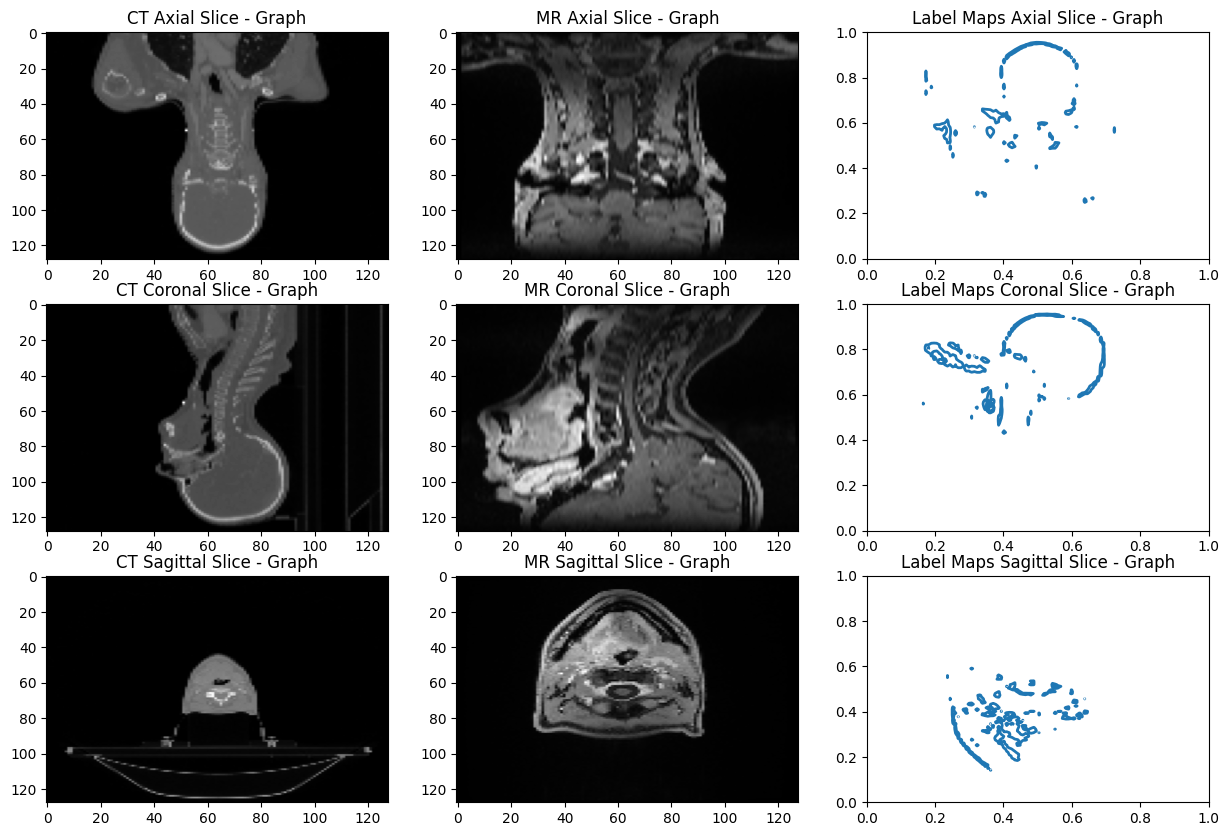

In [ ]:
plot_slices_with_labels(data['image'], data['image'], 'Graph')

###Dataloader and Custom Collate Function


In [ ]:



# Split the loaded data into training and test sets
train_data, test_data = train_test_split(loaded_data_scaled, test_size=0.2, random_state=42)

# Convert the lists of dictionaries to dataset format compatible with DataLoader
train_dataset = [{"image": data["image"], "labels": data["labels"]} for data in train_data]
test_dataset = [{"image": data["image"], "labels": data["labels"]} for data in test_data]

def custom_collate(batch):
    images = torch.tensor(np.array([item["image"] for item in batch]), dtype=torch.float32).to(device)
    labels = torch.tensor(np.array([item["labels"] for item in batch]), dtype=torch.float32).to(device)

    return {"images": images, "labels": labels}

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

from torch.multiprocessing import set_start_method












In [ ]:
#Creating train- and testloader

train_loader = DataLoader(train_dataset, batch_size=2, num_workers=0, shuffle=True, collate_fn=custom_collate, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=2, num_workers=0, shuffle=False, collate_fn=custom_collate, drop_last=True)


#Define Models


In [ ]:
#Model with last layer frozen

def load_model_last_layer(num_output_channels):
    # Load the pre-trained model
    pretrained_model = monai.networks.nets.UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=2,  # Adjust this to the number of classes
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm=monai.networks.layers.Norm.BATCH,
    )
    pretrained_model.load_state_dict(monai.bundle.load(name="spleen_ct_segmentation", bundle_dir="./"))

    class UNetWithLastLayerFineTuning(nn.Module):
        def __init__(self, pretrained_model, num_output_channels):
            super(UNetWithLastLayerFineTuning, self).__init__()

            # Create a UNet model with one input channel
            self.model = pretrained_model

            self.unfreeze_last_layer()

            self.single_channel_conv = torch.nn.Conv3d(2, 1, kernel_size=1).to(device)

            # Final convolution layer with the correct number of output channels
            self.final_conv = torch.nn.Conv3d(2, num_output_channels, kernel_size=1).to(device)
            self.loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)

        def unfreeze_last_layer(self):
            # Freeze all layers except the last layer
            for param in self.model.parameters():
                param.requires_grad = False
            for layer in reversed(list(self.model.children())):
                if isinstance(layer, nn.Conv3d):
                    for param in layer.parameters():
                        param.requires_grad = True
                    break

        def forward(self, inputs):
            output = self.model(self.single_channel_conv(inputs))

            # Pass through the final convolution layer
            output_final = self.final_conv(output)

            return output_final

    # Create an instance of the UNet model with fine-tuning on the last layer
    model = UNetWithLastLayerFineTuning(pretrained_model, num_output_channels).to(device)

    return model
























In [ ]:

#Model with last two layer frozen
def load_model_last_two_layers(num_output_channels):


    # Load the pre-trained model
    pretrained_model = monai.networks.nets.UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=2,  # Adjust this to the number of classes
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm=monai.networks.layers.Norm.BATCH,
    )
    pretrained_model.load_state_dict(monai.bundle.load(name="spleen_ct_segmentation", bundle_dir="./"))

    class UNetWithTwoChannels(nn.Module):
        def __init__(self, pretrained_model, num_output_channels):
            super(UNetWithTwoChannels, self).__init__()

            # Create a UNet model with one input channel
            self.model = pretrained_model

            # Add a new layer with two input channels to combine with the two-channel input
            self.single_channel_conv = torch.nn.Conv3d(2, 1, kernel_size=1).to(device)

            self.unfreeze_last_two_layers()

            # Final convolution layer with the correct number of output channels
            self.final_conv = torch.nn.Conv3d(1, num_output_channels, kernel_size=1).to(device)
            self.loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)

        def unfreeze_last_two_layers(self):

            total_layers = len(list(self.model.children()))

            # Freeze all layers except the last two
            for idx, layer in enumerate(self.model.children()):
                if idx < total_layers - 2:
                    for param in layer.parameters():
                        param.requires_grad = False

        def forward(self, inputs):
            # Combine CT and MR inputs (assuming they are channels)
            output = self.model(self.single_channel_conv(inputs))
            output_final = self.final_conv(self.single_channel_conv(output))

            return output_final


    model = UNetWithTwoChannels(pretrained_model, num_output_channels).to(device)

    return model


In [ ]:
#Model from scratch

class YourModel(torch.nn.Module):
    def __init__(self, num_classes):
        super(YourModel, self).__init__()

        self.unet = monai.networks.nets.UNet(
            spatial_dims=3,
            in_channels=2,  # Two input channels (2 images)
            out_channels=num_classes,
            channels=(16, 32, 64, 128),
            strides=(2, 2, 2, 2),
            num_res_units=2
        )

        self.loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)

    def forward(self, x):
        # Your forward pass here
        return self.unet(x)









#Defining Train and Testfunctions

In [ ]:
import torch
from torch.cuda.amp import GradScaler, autocast

def train_model_with_early_stopping(model, train_loader, optimizer, lr_scheduler, device, epochs, patience=5):
    model.train()
    scaler = GradScaler()

    best_loss = float('inf')
    counter = 0  # Counter for early stopping

    for epoch in range(epochs):
        total_loss = 0.0
        for step, batch_data in enumerate(train_loader):
            inputs, labels = batch_data['images'].to(device), batch_data['labels'].to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs)
                loss = model.loss_function(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_loss}")

        lr_scheduler.step()

        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print(f"Early stopping after {patience} epochs of no improvement.")
            break

    print("Training completed.")










In [ ]:
#test function
def dice_coefficient(predicted, target, threshold=0.6):
    predicted_binary = (predicted > threshold).float()
    target_binary = (target > threshold).float()

    intersection = torch.sum(predicted_binary * target_binary)
    union = torch.sum(predicted_binary) + torch.sum(target_binary)
    dice = (2.0 * intersection) / (union + 1e-8)
    return dice

def threshold_mask(probability_map, threshold=0.7):
    binary_mask = (probability_map > threshold).float()
    return binary_mask


def test_model(model, test_loader, loss_function, device, num_output_channels=30, threshold=0.5):
    model.eval()
    total_test_loss = 0.0
    total_channel_losses = [0.0] * num_output_channels
    total_dice_coefficients = [0.0] * num_output_channels

    with torch.no_grad():  # Disable gradient computation during testing
        for batch_idx, batch in enumerate(test_loader):
            inputs = batch['images'].float().to(device)
            targets = batch['labels'].float().to(device)

            outputs = model(inputs)

            # Threshold predictions to obtain binary masks
            binary_outputs = threshold_mask(torch.sigmoid(outputs), threshold=threshold)

            # Calculate dice loss for the entire batch
            loss = loss_function(outputs, targets)
            total_test_loss += loss.item()

            # Calculate dice loss, Dice coefficient, and update metrics for each channel
            for i in range(num_output_channels):
                channel_losses = loss_function(outputs[:, i, ...], targets[:, i, ...])
                total_channel_losses[i] += channel_losses.item()

                # Calculate Dice coefficient for each channel
                channel_dice = dice_coefficient(threshold_mask(torch.sigmoid(outputs[:, i, ...])), targets[:, i, ...], threshold=threshold)
                total_dice_coefficients[i] += channel_dice.item()

            # Print average Dice loss and Dice coefficient per channel for each batch
            print(f"Batch {batch_idx + 1}/{len(test_loader)}, Dice Loss: {loss.item()}, Dice: {channel_dice.item()}")

            # Visualize the slices with labels for a few samples
            for i in range(min(3, inputs.size(0))):
                plot_slices_with_labels(
                    inputs[i].cpu().numpy(),
                    targets[i].cpu().numpy(),
                    binary_outputs[i].cpu().numpy(),
                    f"Batch {batch_idx + 1}"
                )

    # Calculate and print average statistics across all batches
    average_test_loss = total_test_loss / len(test_loader)
    print(f"Overall Test Loss: {average_test_loss}")

    average_channel_losses = [loss / len(test_loader) for loss in total_channel_losses]
    print(f"Average Dice Loss per Channel: {average_channel_losses}")

    average_dice_coefficients = [dice / len(test_loader) for dice in total_dice_coefficients]
    print(f"Average Dice Coefficient per Channel: {average_dice_coefficients}")



In [ ]:
#Plot ffunction ffor image label, ground thruth and prediction

def plot_slices_with_labels(image, labels,predictions, title):
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'brown', 'pink', 'gray']

    # Create a ListedColormap using the specified colors
    custom_cmap = ListedColormap(colors * int(len(labels) / len(colors)))


    ct_x_slice = image[0][:, image[0].shape[1] // 2, :]
    ct_y_slice = image[0][:, :, image[0].shape[2] // 2]
    ct_z_slice = image[0][image[0].shape[0] // 2, :, :]

    mr_x_slice = image[1][:, image[1].shape[1] // 2, :]
    mr_y_slice = image[1][:, :, image[1].shape[2] // 2]
    mr_z_slice = image[1][image[1].shape[0] // 2, :, :]

    label_x_slice = []
    label_y_slice = []
    label_z_slice = []

    prediction_x_slice = []
    prediction_y_slice = []
    prediction_z_slice = []

    for i in range(len(labels)):
      label_x_slice.append(labels[i][:, labels[i].shape[1] // 2, :])
      label_y_slice.append(labels[i][:, :, labels[i].shape[2] // 2])
      label_z_slice.append(labels[i][labels[i].shape[0] // 2, :, :])

    for i in range(len(labels)):
      prediction_x_slice.append(predictions[i][:, predictions[i].shape[1] // 2, :])
      prediction_y_slice.append(predictions[i][:, :, predictions[i].shape[2] // 2])
      prediction_z_slice.append(predictions[i][predictions[i].shape[0] // 2, :, :])

    plt.figure(figsize=(15, 10))

    # Axial slices
    plt.subplot(3, 4, 1)
    plt.imshow(image[0][:, image[0].shape[1] // 2, :], cmap='gray', aspect='auto')
    plt.title('CT Axial Slice - ' + title)

    plt.subplot(3, 4, 2)
    plt.imshow(image[1][:, image[1].shape[1] // 2, :], cmap='gray', aspect='auto')
    plt.title('MR Axial Slice - ' + title)

    from matplotlib.patches import Rectangle



    plt.subplot(3, 4, 3)
    for i, binary_map in enumerate(label_x_slice):
      color = plt.cm.tab20(i / 30)  # Choose a color from the Tab20 colormap
      contours = plt.contour(binary_map, levels=[0.5], colors=[color], linewidths=2, extent=[0, 1, 0, 1])

    plt.title('Label Maps Axial Slice - ' + title)

    plt.subplot(3, 4, 4)
    for i, binary_map in enumerate(prediction_x_slice):

      color = plt.cm.tab20(i / 30)  # Choose a color from the Tab20 colormap
      contours = plt.contour(binary_map, levels=[0.5], colors=[color], linewidths=2, extent=[0, 1, 0, 1])

    plt.title('Predicted Maps Axial Slice - ' + title)


    # Coronal slices
    plt.subplot(3, 4, 5)
    plt.imshow(image[0][:, :, image[0].shape[2] // 2], cmap='gray', aspect='auto')
    plt.title('CT Coronal Slice - ' + title)

    plt.subplot(3, 4, 6)
    plt.imshow(image[1][:, :, image[1].shape[2] // 2], cmap='gray', aspect='auto')
    plt.title('MR Coronal Slice - ' + title)

    plt.subplot(3, 4, 7)
    for i, binary_map in enumerate(label_y_slice):
      color = plt.cm.tab20(i / 30)  # Choose a color from the Tab20 colormap
      contours = plt.contour(binary_map, levels=[0.5], colors=[color], linewidths=2, extent=[0, 1, 0, 1])

    plt.title('Label Maps Coronal Slice - ' + title)

    plt.subplot(3, 4, 8)
    for i, binary_map in enumerate(prediction_y_slice):
      color = plt.cm.tab20(i / 30)  # Choose a color from the Tab20 colormap
      contours = plt.contour(binary_map, levels=[0.5], colors=[color], linewidths=2, extent=[0, 1, 0, 1])

    plt.title('Predictions Maps Coronal Slice - ' + title)


    # Sagittal slices
    plt.subplot(3, 4, 9)
    plt.imshow(image[0][image[0].shape[0] // 2, :, :], cmap='gray', aspect='auto')
    plt.title('CT Sagittal Slice - ' + title)

    plt.subplot(3, 4, 10)
    plt.imshow(image[1][image[1].shape[0] // 2, :, :], cmap='gray', aspect='auto')
    plt.title('MR Sagittal Slice - ' + title)

    plt.subplot(3, 4, 11)
    for i, binary_map in enumerate(label_z_slice):
      color = plt.cm.tab20(i / 30)  # Choose a color from the Tab20 colormap
      contours = plt.contour(binary_map, levels=[0.5], colors=[color], linewidths=2, extent=[0, 1, 0, 1])

    plt.title('Label Maps Sagittal Slice - ' + title)


    plt.subplot(3, 4, 12)
    for i, binary_map in enumerate(prediction_z_slice):
      color = plt.cm.tab20(i / 30)  # Choose a color from the Tab20 colormap
      contours = plt.contour(binary_map, levels=[0.5], colors=[color], linewidths=2, extent=[0, 1, 0, 1])
    plt.title('Prediction Maps Sagittal Slice - ' + title)

    plt.show()

#Train the models

In [ ]:

model1 = YourModel(num_classes=30).to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=5e-3, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer1, T_max=10)


#train_model_with_early_stopping(model1, train_loader, optimizer1, lr_scheduler, device, epochs=250, patience=20)

In [ ]:

model2 = load_model_last_layer(30).to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=5e-2, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer2, T_max=10)



#train_model_with_early_stopping(model2, train_loader, optimizer, lr_scheduler, device, epochs=250, patience=20)

In [ ]:

model3 = load_model_last_two_layers(30).to(device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=5e-3, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer3, T_max=10)



#train_model_with_early_stopping(model3, train_loader, optimizer3, lr_scheduler, device, epochs=250, patience=20)

#Save and Load Models





In [ ]:
import torch
from google.colab import drive

def save_load_model(model, optimizer, action, model_name='model.pth'):
    drive.mount('/content/drive')

    # Define the path
    model_path = f'/content/drive/My Drive/{model_name}'

    if action == 'save':
        # Save the model and optimizer
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, model_path)
        print(f'Model saved at: {model_path}')

    elif action == 'load':
        # Load the model and optimizer
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f'Model loaded from: {model_path}')

    else:
        print("Invalid action. Please use 'save' or 'load'.")


In [ ]:
save_load_model(model1, optimizer1, action='save', model_name='model1.pth')
save_load_model(model2, optimizer2, action='save', model_name='model2.pth')
save_load_model(model3, optimizer3, action='save', model_name='model3.pth')

In [ ]:
save_load_model(model1, optimizer1, action='load', model_name='model1.pth')
save_load_model(model2, optimizer2, action='load', model_name='model2.pth')
save_load_model(model3, optimizer3, action='load', model_name='model3.pth')

In [ ]:
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)

# Test and Evaluate Models

In [ ]:

test_model(model3, test_loader, loss_function, device)

In [ ]:
test_model(model2, test_loader, loss_function, device)

In [ ]:
test_model(model1, test_loader, loss_function, device)